In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import os

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from google.colab import drive

Using TensorFlow backend.


读取保存的data和label

In [0]:
labels=np.load('/content/drive/My Drive/data_model/label_10.npy')
print(labels)
print(np.shape(labels))

data = np.load('/content/drive/My Drive/data_model/48_64_3.npy')
print(np.shape(data))

['0' '0' '0' ... '7' '7' '7']
(15200,)
(15200, 48, 64, 3)


In [0]:
data = np.array(data, dtype= "float") / 255.0
labels = np.array(labels)
for a in range(8):
  print("number of ",a,"data is:",list(labels).count(str(a)))

# 对label进行one-hot编码
le = LabelEncoder().fit(labels)   # LabelEncoder可以将标签分配一个0—n_classes-1之间的编码 

# transform用来标准化，将labels中'not_smiling'和‘smiling’的数据转换成0和1的形式
labels = np_utils.to_categorical(le.transform(labels), 8)  # 2是num_class表示输出的是2列数据的意思
print(labels)


number of  0 data is: 1930
number of  1 data is: 1900
number of  2 data is: 1900
number of  3 data is: 1896
number of  4 data is: 1892
number of  5 data is: 1882
number of  6 data is: 1900
number of  7 data is: 1900
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


简单随机8/2分割数据集

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, 
                                                 stratify = labels, random_state = 42)

train，test数据集形状测试

In [0]:
print(trainX.ndim)
print(trainX[0,0,0,:])
print(np.shape(trainY))
print(trainY)
print(np.shape(testX))
print(testY)

4
[0.63137255 0.47058824 0.37254902]
(12160, 8)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
(3040, 48, 64, 3)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


定义CNN网络

In [0]:
model = Sequential()
model.add(Conv2D(input_shape=(48,64,3),kernel_size=(5,5),filters=20,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model.add(Conv2D(kernel_size=(5, 5), filters=50,  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [0]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

H = model.fit(trainX, trainY, validation_data = (testX, testY),
              batch_size = 64, epochs = 15, verbose = 1)  #verbose = 1显示进度条



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 38907 samples, validate on 9727 samples
Epoch 1/15
38907/38907 [==============================] - 22s 567us/step - loss: 0.1939 - acc: 0.9283 - val_loss: 0.1299 - val_acc: 0.9500
Epoch 2/15
38907/38907 [==============================] - 14s 368us/step - loss: 0.1057 - acc: 0.9601 - val_loss: 0.1003 - val_acc: 0.9616
Epoch 3/15
38907/38907 [==============================] - 14s 368us/step - loss: 0.0839 - acc: 0.9677 - val_loss: 0.0832 - val_acc: 0.9683
Epoch 4/15
38907/38907 [==============================] - 14s 367us/step - loss: 0.0727 - acc: 0.9715 - val_loss: 0.0709 - val_acc: 0.9722
Epoch 5/15
38907/38907 [==============================] - 14s 367us/step - loss: 0.0675 - acc: 0.9732 - val_loss: 0.0682 - val_acc: 0.9723
Epoch 6/15
38907/38907 [==============================] - 15s 376us/step - loss: 0.0612 - acc: 0.9756 - val_loss: 0.0613 - val_acc: 0.9759
Epoch 7/15
38907/389

可视化各种动作情况下的精度，f值等数据并保存训练好的model

In [0]:
predictions = model.predict(testX, batch_size = 64)
print(np.shape(predictions))
print(predictions.argmax(axis =1))
#0列1行返回位置所以合起来就是3040行中0-8预测值最大的是哪个

print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                           target_names = le.classes_)) 
#https://blog.csdn.net/akadiao/article/details/78788864
model.save("/content/drive/My Drive/data_model/act_CNN_pro.hdf5")

(9727, 8)
[1 0 7 ... 6 1 5]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1235
           1       0.85      0.96      0.91      1216
           2       0.98      0.92      0.95      1216
           3       0.95      0.93      0.94      1214
           4       0.98      0.93      0.96      1210
           5       0.92      0.94      0.93      1204
           6       1.00      1.00      1.00      1216
           7       1.00      1.00      1.00      1216

    accuracy                           0.95      9727
   macro avg       0.95      0.95      0.95      9727
weighted avg       0.95      0.95      0.95      9727



可视化epoch回数和loss，accuracy间的关系

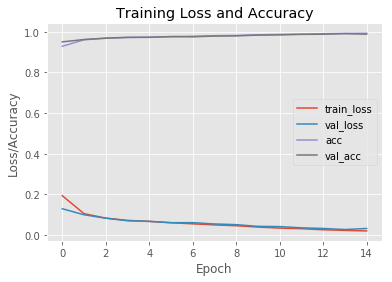

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label = "acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()